Logistic Map Equation: x
n+1
​
 =r⋅x
n
​
 ⋅(1−x
n
​
 )

- x_n is the current state (a number between 0 and 1).

- x_{n+1} is the next value in the sequence.

- r is the growth rate parameter.

This block:

- Introduces the logistic map function

- Lets us generate sequences with different r values

- Plots them to visually understand convergence, cycles, and chaos

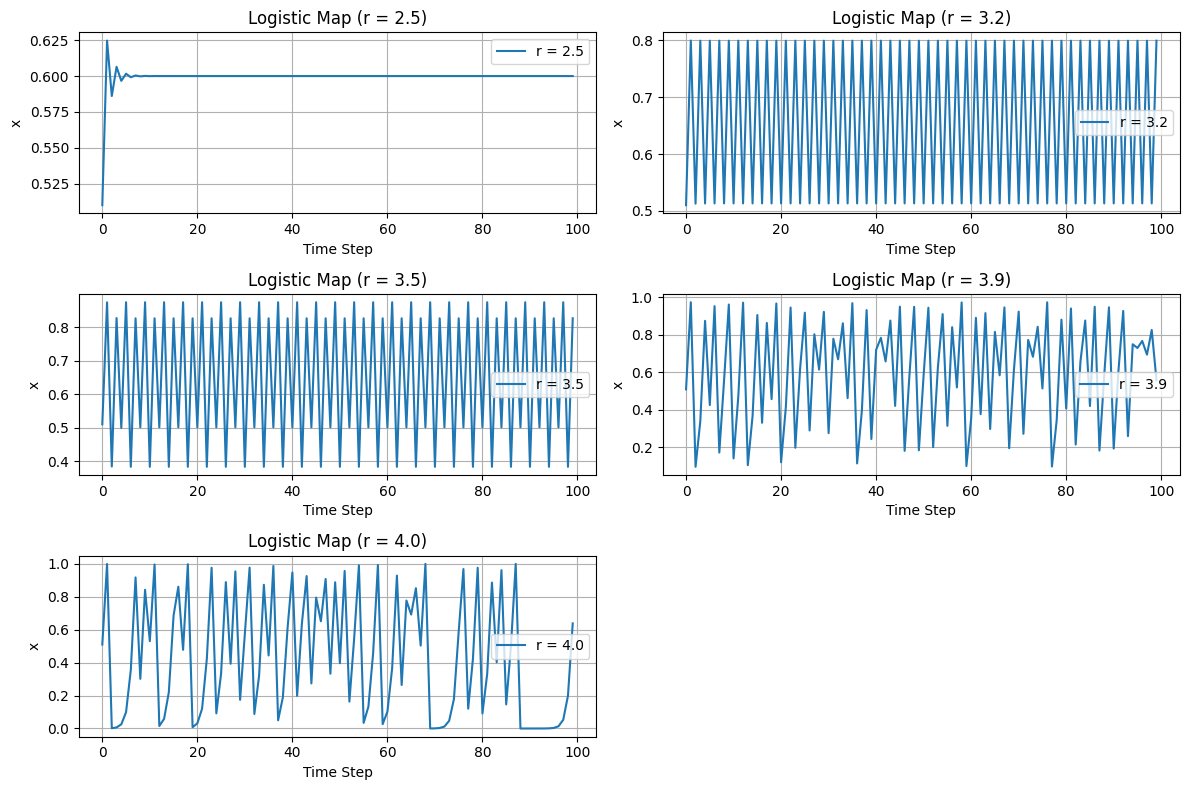

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Define the logistic map function
def logistic_map(x0: float, r: float, n: int = 100) -> np.ndarray:
    """
    Generates a logistic map sequence.

    Args:
        x0 (float): Initial value (between 0 and 1).
        r (float): Growth rate parameter (between 0 and 4).
        n (int): Number of time steps.

    Returns:
        np.ndarray: Sequence of logistic map values.
    """
    seq = np.zeros(n)
    seq[0] = x0
    for i in range(1, n):
        seq[i] = r * seq[i - 1] * (1 - seq[i - 1])
    return seq

# Plot logistic map sequences for different r values
def plot_logistic_map_examples(x0: float = 0.51, n: int = 100):
    """
    Plots logistic map sequences for several r values to visualize behavior.

    Args:
        x0 (float): Initial value.
        n (int): Number of iterations.
    """
    r_values = [2.5, 3.2, 3.5, 3.9, 4.0]
    plt.figure(figsize=(12, 8))

    for i, r in enumerate(r_values, 1):
        x0_safe = random.uniform(0.11, 0.89)
        seq = logistic_map(x0, r, n)
        plt.subplot(3, 2, i)
        plt.plot(seq, label=f"r = {r}")
        plt.title(f"Logistic Map (r = {r})")
        plt.xlabel("Time Step")
        plt.ylabel("x")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

# 🔍 Run the plot function to see different behaviors
plot_logistic_map_examples()


- Low r (e.g., 2.5) = stable

- Mid r (e.g., 3.3) = periodic

- High r (e.g., 3.8 – 4.0) = chaotic

Generate synthetic sequences using random r values

Label each sequence as:

- 0 = stable (low r)

- 1 = periodic (mid r)

- 2 = chaotic (high r)

Create a full dataset we can later feed into a classifier

In [4]:
import random
from typing import Tuple, List

# Label assignment based on r value
def label_from_r(r: float) -> int:
    """
    Assigns a regime label based on the value of r.

    Args:
        r (float): Growth rate.

    Returns:
        int: Label (0 = stable, 1 = periodic, 2 = chaotic)
    """
    if r < 3.0:
        return 0  # Stable regime
    elif 3.0 <= r < 3.57:
        return 1  # Periodic regime
    else:
        return 2  # Chaotic regime

# Create one labeled sequence
def generate_labeled_sequence(n: int = 100) -> Tuple[np.ndarray, int]:
    """
    Generates a single logistic map sequence and its regime label.

    Args:
        n (int): Sequence length.

    Returns:
        Tuple: (sequence, label)
    """
    r = round(random.uniform(2.5, 4.0), 4)
    x0 = random.uniform(0.1, 0.9)
    sequence = logistic_map(x0, r, n)
    label = label_from_r(r)
    return sequence, label

# Generate a full dataset
def generate_dataset(num_samples: int = 1000, n: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates a dataset of logistic sequences with regime labels.

    Args:
        num_samples (int): Number of sequences to generate.
        n (int): Length of each sequence.

    Returns:
        Tuple[np.ndarray, np.ndarray]: X (sequences), y (labels)
    """
    X, y = [], []

    for _ in range(num_samples):
        sequence, label = generate_labeled_sequence(n)
        X.append(sequence)
        y.append(label)

    return np.array(X), np.array(y)

# Example: Generate small dataset and view label counts
X, y = generate_dataset(num_samples=500, n=100)

# Check class distribution
import collections
print("Label distribution:", collections.Counter(y))

Label distribution: Counter({np.int64(1): 197, np.int64(0): 157, np.int64(2): 146})


Used controlled r ranges to simulate different market regimes

Created 500 synthetic sequences (X) and regime labels (y)

Now we can visualize, split, and train on this dataset

Visualize:

- Randomly samples from X, y

- Plots sequences grouped by class (0 = stable, 1 = periodic, 2 = chaotic)

Helps us verify that the labels match the visual behavior

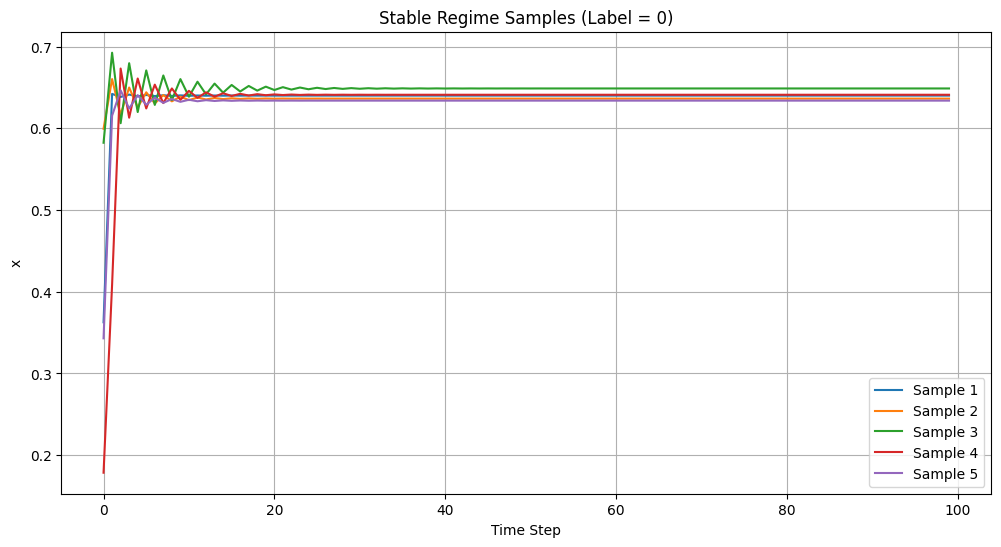

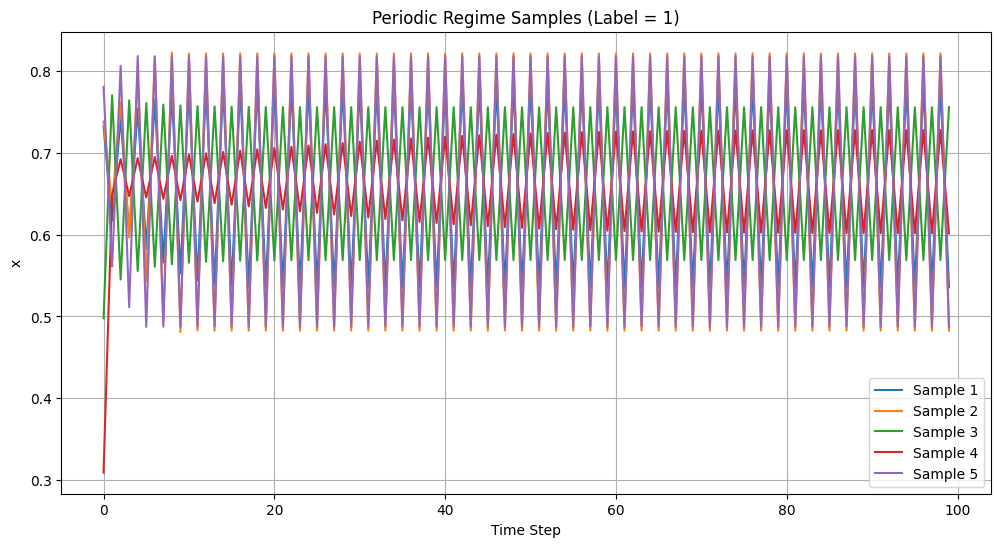

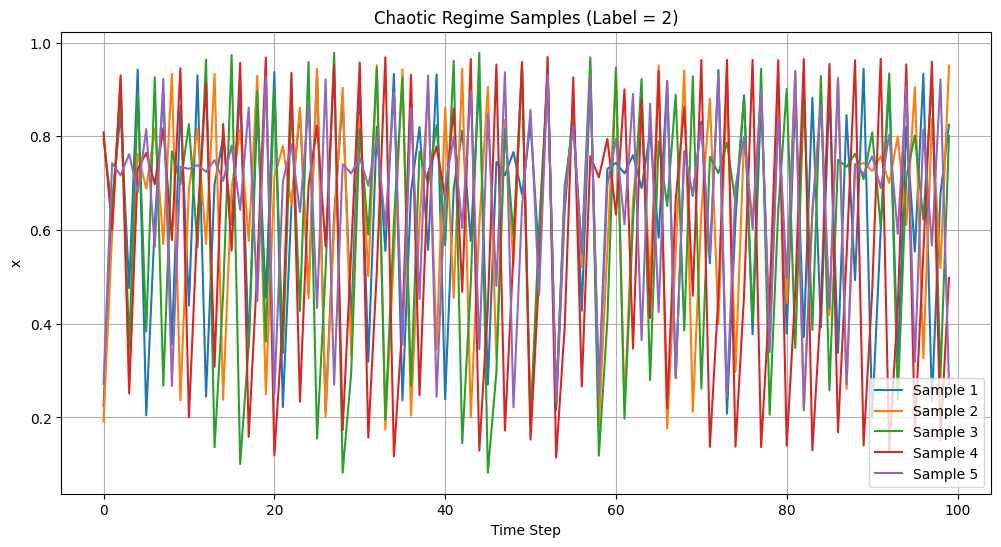

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Helper: Plot N random sequences for a given class
def plot_class_samples(X: np.ndarray, y: np.ndarray, target_label: int, n_samples: int = 5):
    """
    Plots sample sequences from a specified class.

    Args:
        X (np.ndarray): Dataset of sequences.
        y (np.ndarray): Labels (0=stable, 1=periodic, 2=chaotic).
        target_label (int): Class to visualize.
        n_samples (int): Number of sequences to plot.
    """
    indices = np.where(y == target_label)[0]
    chosen = np.random.choice(indices, n_samples, replace=False)

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(chosen):
        plt.plot(X[idx], label=f"Sample {i+1}")

    regime_name = ["Stable", "Periodic", "Chaotic"][target_label]
    plt.title(f"{regime_name} Regime Samples (Label = {target_label})")
    plt.xlabel("Time Step")
    plt.ylabel("x")
    plt.grid(True)
    plt.legend()
    plt.show()

# View class 0 (stable)
plot_class_samples(X, y, target_label=0)

# View class 1 (periodic)
plot_class_samples(X, y, target_label=1)

# View class 2 (chaotic)
plot_class_samples(X, y, target_label=2)

Stable: Sequences that flatten out

Periodic: Repeating waveforms (2, 4, 8 points)

Chaotic: No repeating pattern, jittery

Each of these sequences looks completely different — even though they're all generated by the same equation.

No fixed pattern. No periodic rhythm. Just deterministic unpredictability.

But it's not random — it's chaotic: sensitive to initial conditions, governed by internal structure (nonlinear dynamics).

Split X, y into training and testing sets

Normalize (optional, but improves convergence)

Convert to PyTorch tensors

Create DataLoaders for training

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Normalize sequences (standardization: mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # Fit only on train
X_test_scaled = scaler.transform(X_test)

# Step 3: Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Step 4: Create TensorDatasets and DataLoaders
batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


This CNN will:

- Take a 1D time series (length 100)

- Apply temporal convolutions to learn patterns

- Use global pooling to summarize features

- Output one of 3 regime classes

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# 1D CNN model for sequence classification
class ChaosCNN(nn.Module):
    def __init__(self, input_length=100, num_classes=3):
        super(ChaosCNN, self).__init__()

        # Feature extractors
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Outputs shape: (batch_size, channels, 1)

        # Final classifier
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        x = x.unsqueeze(1)  # Add channel dim (batch_size, 1, sequence_length)

        x = F.relu(self.bn1(self.conv1(x)))  # (batch_size, 32, seq_len)
        x = F.relu(self.bn2(self.conv2(x)))  # (batch_size, 64, seq_len)

        x = self.global_pool(x).squeeze(2)   # (batch_size, 64)
        out = self.fc(x)                     # (batch_size, num_classes)
        return out


Conv1d:	Extracts local patterns across the time dimension

BatchNorm1d:	Stabilizes training and speeds up convergence

AdaptiveAvgPool1d:	Summarizes the sequence into global stats

Linear:	Final decision layer for 3-class classification

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChaosCNN().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=15):
    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)

        avg_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)

        # Evaluation after each epoch
        model.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(y_batch.numpy())

        acc = accuracy_score(all_labels, all_preds)
        test_accuracies.append(acc)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Test Accuracy: {acc:.4f}")

    return train_losses, test_accuracies

# Train the model
train_losses, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, device, epochs=15
)


Epoch 1/15 - Loss: 0.7872 - Test Accuracy: 0.8500
Epoch 2/15 - Loss: 0.5076 - Test Accuracy: 0.8700
Epoch 3/15 - Loss: 0.4212 - Test Accuracy: 0.8900
Epoch 4/15 - Loss: 0.3675 - Test Accuracy: 0.9100
Epoch 5/15 - Loss: 0.3137 - Test Accuracy: 0.9200
Epoch 6/15 - Loss: 0.2720 - Test Accuracy: 0.9300
Epoch 7/15 - Loss: 0.2403 - Test Accuracy: 0.9300
Epoch 8/15 - Loss: 0.2136 - Test Accuracy: 0.9300
Epoch 9/15 - Loss: 0.2118 - Test Accuracy: 0.9300
Epoch 10/15 - Loss: 0.1760 - Test Accuracy: 0.9400
Epoch 11/15 - Loss: 0.1590 - Test Accuracy: 0.9200
Epoch 12/15 - Loss: 0.1466 - Test Accuracy: 0.9900
Epoch 13/15 - Loss: 0.1325 - Test Accuracy: 0.9400
Epoch 14/15 - Loss: 0.1291 - Test Accuracy: 0.9300
Epoch 15/15 - Loss: 0.1185 - Test Accuracy: 0.9800


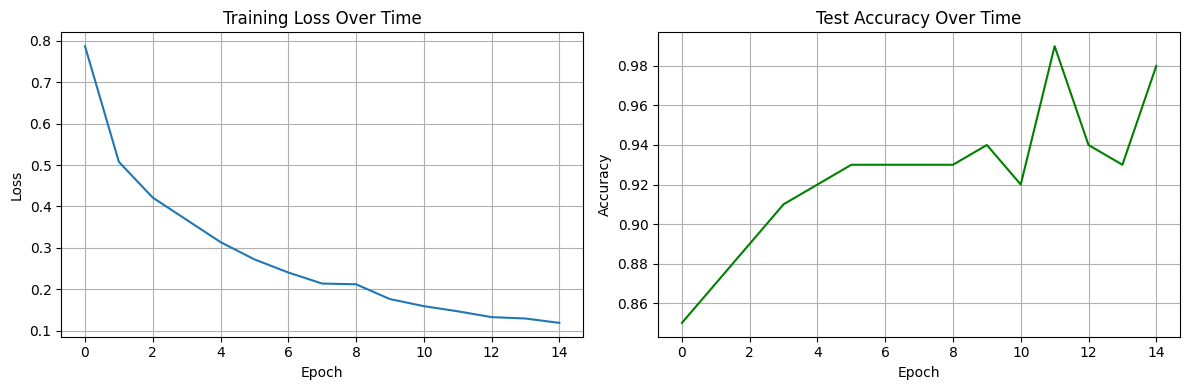

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Test Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Time")
plt.grid(True)

plt.tight_layout()
plt.show()


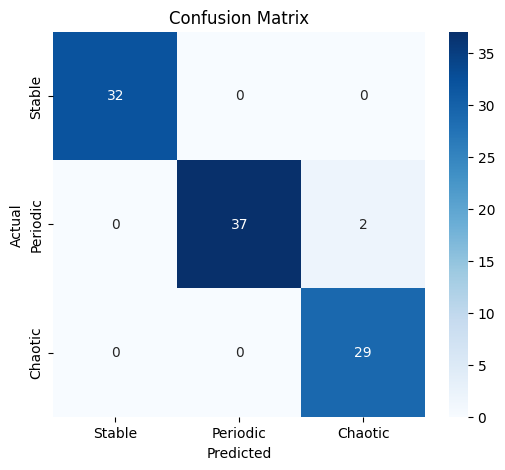

              precision    recall  f1-score   support

      Stable       1.00      1.00      1.00        32
    Periodic       1.00      0.95      0.97        39
     Chaotic       0.94      1.00      0.97        29

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [11]:
# Final performance evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["Stable", "Periodic", "Chaotic"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))


Input an r value (between 2.5 and 4.0)

Generate a logistic map sequence

Feed it to your trained model

Predict the regime

Plot the sequence and overlay the prediction

In [12]:
# Label map for decoding
label_map = {0: "Stable", 1: "Periodic", 2: "Chaotic"}

def predict_regime(r_value: float, model, scaler, device, sequence_length=100):
    """
    Generates a logistic sequence for a given r, feeds to model, and predicts regime.
    """
    assert 2.5 <= r_value <= 4.0, "r must be between 2.5 and 4.0"

    # Generate sequence
    x0 = np.random.uniform(0.1, 0.9)
    sequence = logistic_map(x0, r_value, sequence_length).reshape(1, -1)

    # Standardize using training scaler
    sequence_scaled = scaler.transform(sequence)

    # Convert to tensor
    sequence_tensor = torch.tensor(sequence_scaled, dtype=torch.float32).to(device)

    # Model inference
    model.eval()
    with torch.no_grad():
        output = model(sequence_tensor)
        pred_class = torch.argmax(output, dim=1).item()

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(sequence.flatten(), label=f"r = {r_value}")
    plt.title(f"Predicted Regime: {label_map[pred_class]} (Class {pred_class})")
    plt.xlabel("Time Step")
    plt.ylabel("x")
    plt.grid(True)
    plt.legend()
    plt.show()

    return label_map[pred_class]


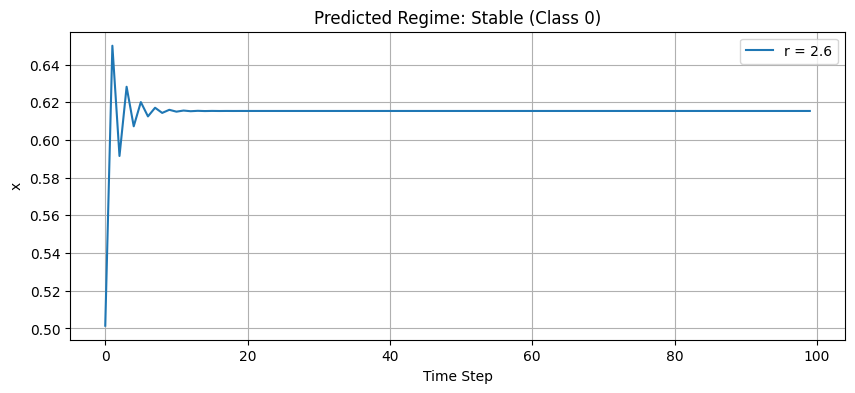

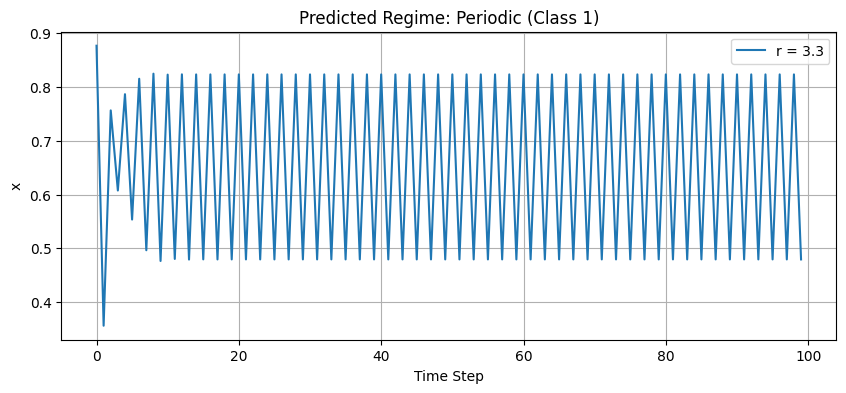

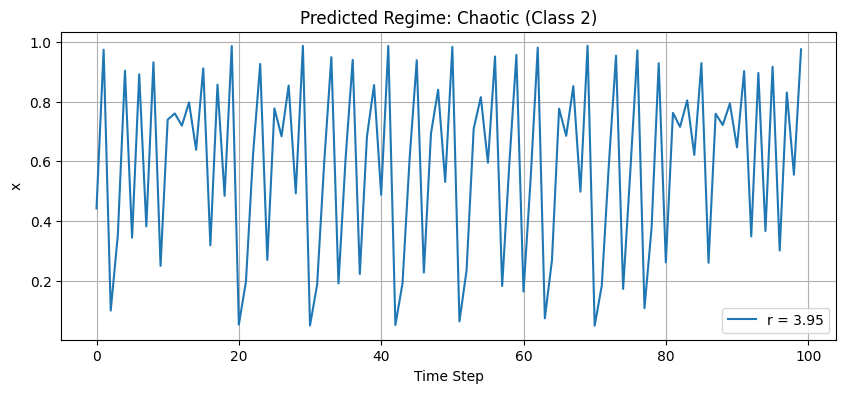

'Chaotic'

In [13]:
predict_regime(2.6, model, scaler, device)
predict_regime(3.3, model, scaler, device)
predict_regime(3.95, model, scaler, device)